In [2]:
# %load_ext autoreload
# %autoreload 2
from paper import *
from animation import DynamicsAnimation
from tqdm import tqdm
from lmfit import minimize, Parameters

In [3]:
def power_law(x, gamma, a):
    return a * x ** -gamma

def residual(params, x, data, uncertainty):
    gamma = params["gamma"]
    a = params["a"]
    model = power_law(x, gamma, a)
    return (data - model) / uncertainty

In [4]:
M0 = 4
levels = 8
alpha = 2.5

# links = get_HMN(M0, levels, alpha)
# np.save("data/links", links)
# links = np.load("data/links.npy")
# print(f"The network has {len(links)} nodes.")
# plot_HMN(links)

In [4]:
def determine_kappa(num_rep, T, precision, kappa_min, kappa_max, start=200):
    while kappa_max - kappa_min > precision:
        kappa = 0.5 * (kappa_min + kappa_max)
        print(f"Trying out kappa = {kappa}")
        initials = np.random.randint(0, 2, (num_rep, len(links)), dtype=np.uint8)
        density = np.zeros(T+1)
        for i in tqdm(range(num_rep)):
            # print(".", end="")
            data = run_dynamics(links, initials[i], T, kappa)
            density += np.mean(data, axis=1)
        density /= num_rep

        params = Parameters()
        params.add("gamma", value=1.0, min=0.0)
        params.add("a", value=1.0, min=0.0, max=1.0)
        # params.add("b", value=0.0, min=0.0, max=1.0)
        out = minimize(residual, params,args=(np.arange(T+1)[start:], density[start:], np.ones(T+1-start)))
        gamma_opt = out.params["gamma"].value
        a_opt = out.params["a"].value
        # b_opt = out.params["b"].value
        density_fitted = power_law(np.arange(T+1)[start:], gamma_opt, a_opt)#, b_opt)
        plt.title(f"gamma = {gamma_opt}")
        plt.plot(density, label="data")
        plt.plot(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(density, label="data")
        plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        flag = input("Next step: go down [d] or up [u]? ")
        if "d" in flag:
            kappa_max = kappa
        elif "u" in flag:
            kappa_min = kappa
        elif "q" in flag:
            print("Quitting instantly...")
            return 0
        else:
            print("Invalid input, ending now...")
            break
    print(" ")
    print(f"kappa_min: {kappa_min}")
    data = run_dynamics(links, initials[i], T, kappa_min)
    plot_dynamics(data)
    print(f"kappa: {kappa}")
    data = run_dynamics(links, initials[i], T, kappa)
    plot_dynamics(data)
    print(f"kappa_max: {kappa_max}")
    data = run_dynamics(links, initials[i], T, kappa_max)
    plot_dynamics(data)

In [5]:
def determine_kappa_auto(num_rep, T, num_trials, kappa_min, kappa_max, start=200, HMN_per_rep=False):
    for kappa in np.linspace(kappa_min, kappa_max, num_trials):
        links = get_HMN(M0, levels, alpha)
        print(f"Trying out kappa = {kappa}")
        # Running experiment
        initials = np.random.randint(0, 2, (num_rep, len(links)), dtype=np.uint8)
        density = np.zeros(T+1)
        for i in tqdm(range(num_rep)):
            # print(".", end="")
            if HMN_per_rep:
                links = get_HMN(M0, levels, alpha)
            data = run_dynamics(links, initials[i], T, kappa)
            density += np.mean(data, axis=1)
        density /= num_rep

        # Fitting data
        params = Parameters()
        params.add("gamma", value=1.0, min=0.0)
        params.add("a", value=1.0, min=0.0, max=1.0)
        # params.add("b", value=0.0, min=0.0, max=1.0)
        out = minimize(residual, params,args=(np.arange(T+1)[start:], density[start:], np.ones(T+1-start)))
        gamma_opt = out.params["gamma"].value
        a_opt = out.params["a"].value
        # b_opt = out.params["b"].value
        density_fitted = power_law(np.arange(T+1)[start:], gamma_opt, a_opt)#, b_opt)

        # Plotting results
        plt.title(f"gamma = {gamma_opt}")
        plt.plot(density, label="data")
        # plt.plot(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(density, label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()
        plt.title(f"gamma = {gamma_opt}")
        plt.loglog(np.arange(T+1)[start:], density[start:], label="data")
        # plt.loglog(np.arange(T+1)[start:], density_fitted, label="fit")
        plt.legend()
        plt.show()

In [6]:
# num_rep = 100
# T = len(links) * 20
# precision = 0.00001
# kappa_min = 0.15
# kappa_max = 0.175

# determine_kappa(num_rep, T, precision, kappa_min, kappa_max, start=200)

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15


100%|██████████| 100/100 [21:30<00:00, 12.91s/it]


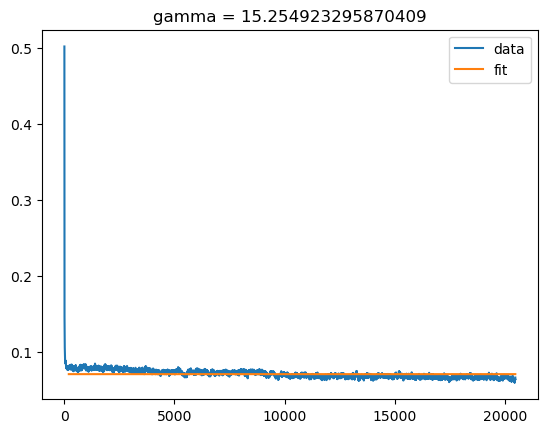

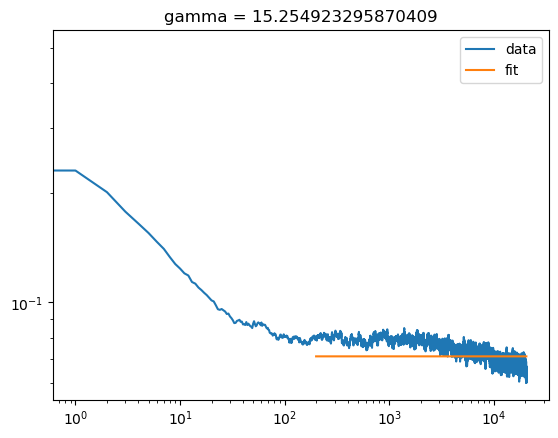

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1502155172413793


100%|██████████| 100/100 [20:46<00:00, 12.46s/it]


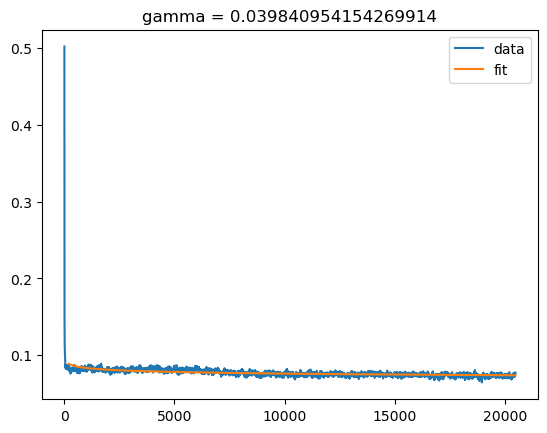

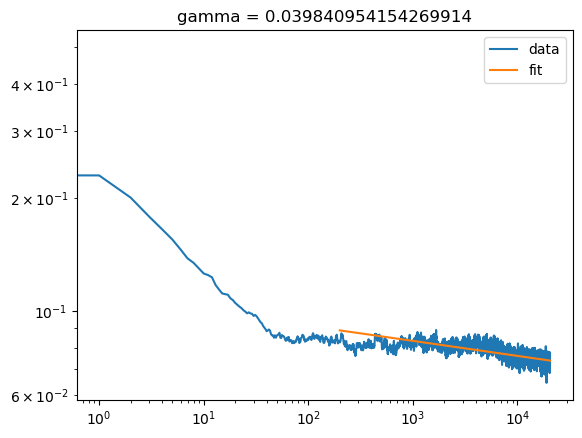

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1504310344827586


100%|██████████| 100/100 [20:17<00:00, 12.17s/it]


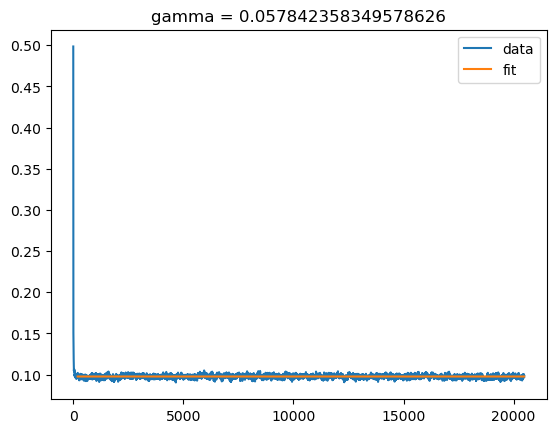

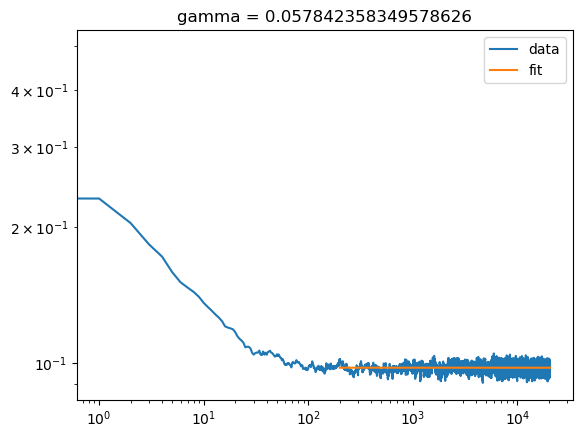

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15064655172413793


100%|██████████| 100/100 [20:05<00:00, 12.05s/it]


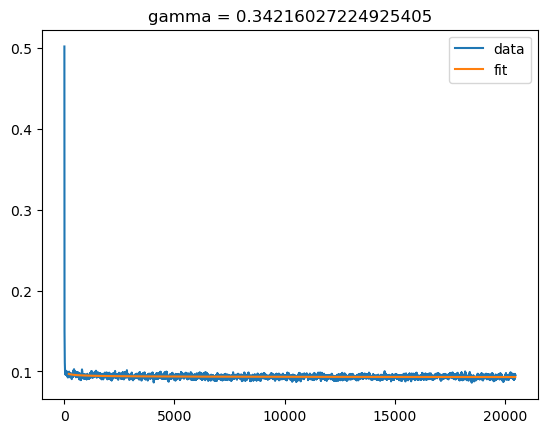

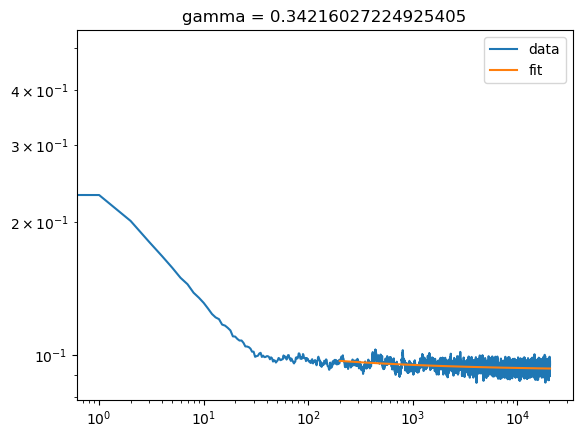

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15086206896551724


100%|██████████| 100/100 [21:55<00:00, 13.16s/it]


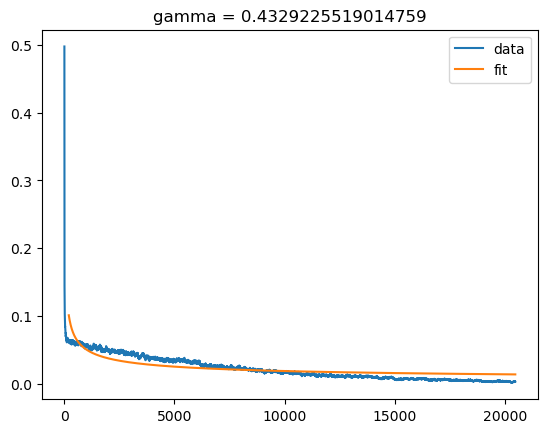

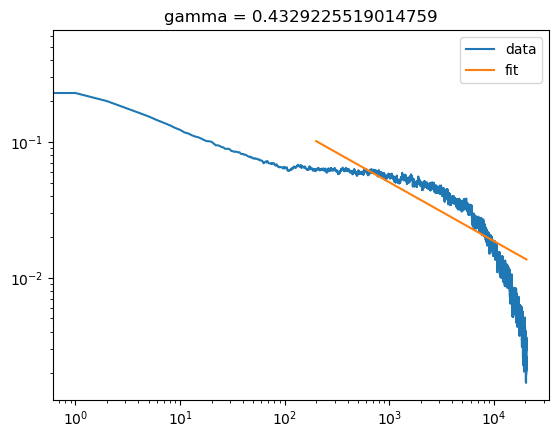

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15107758620689654


100%|██████████| 100/100 [20:25<00:00, 12.25s/it]


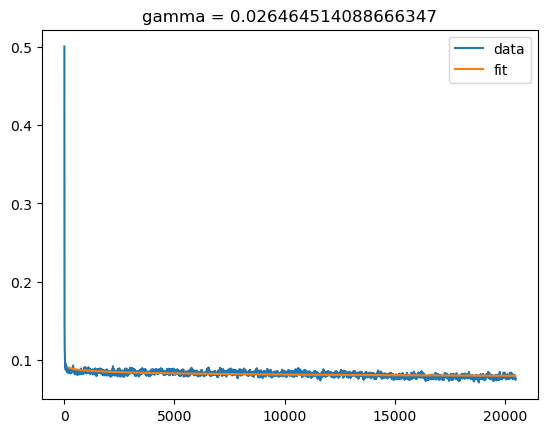

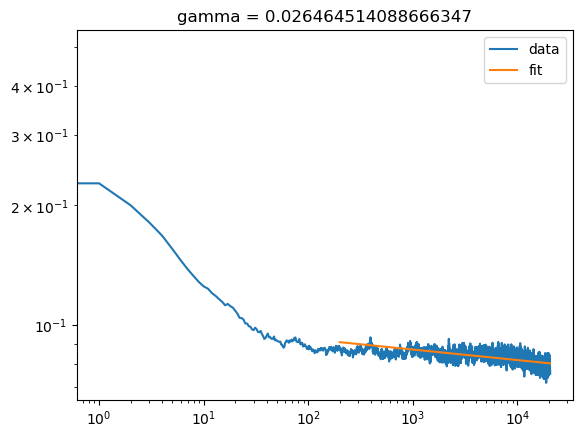

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15129310344827585


100%|██████████| 100/100 [19:59<00:00, 12.00s/it]


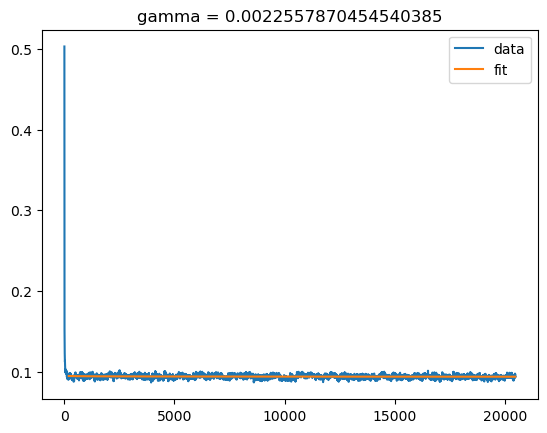

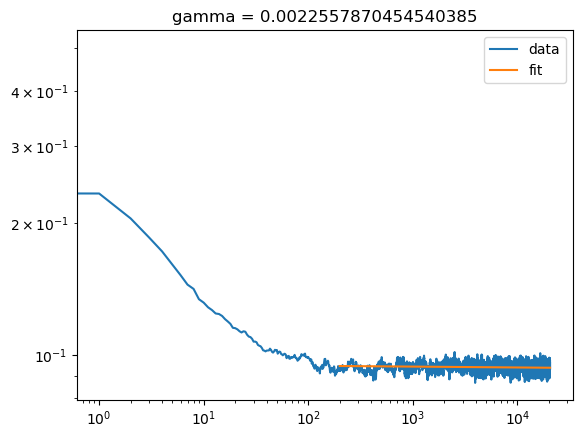

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15150862068965518


100%|██████████| 100/100 [20:35<00:00, 12.35s/it]


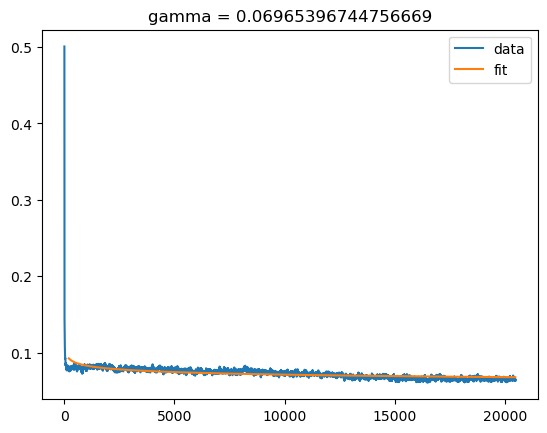

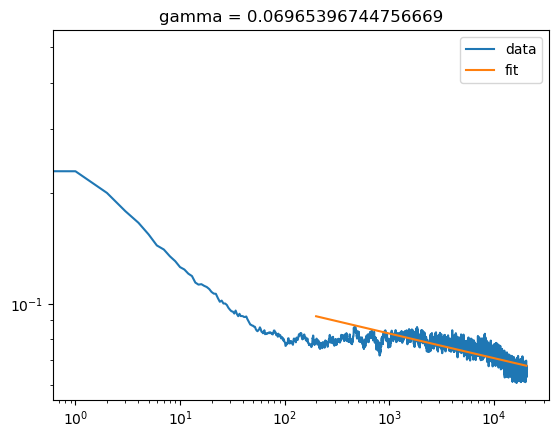

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15172413793103448


100%|██████████| 100/100 [20:22<00:00, 12.23s/it]


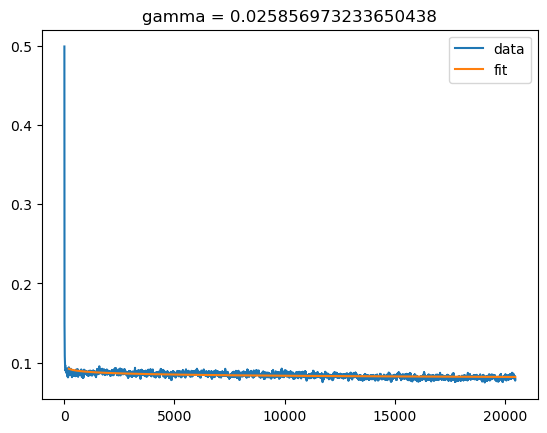

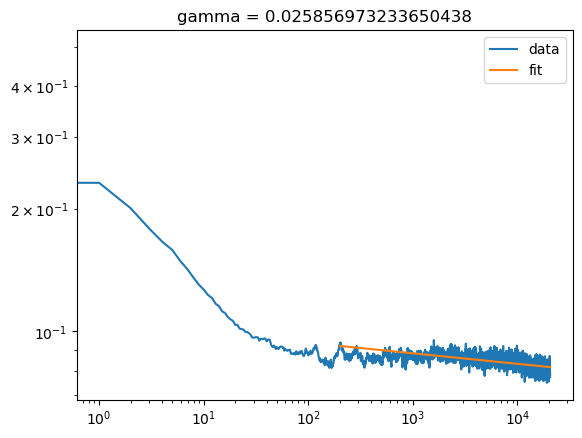

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15193965517241378


100%|██████████| 100/100 [20:48<00:00, 12.49s/it]


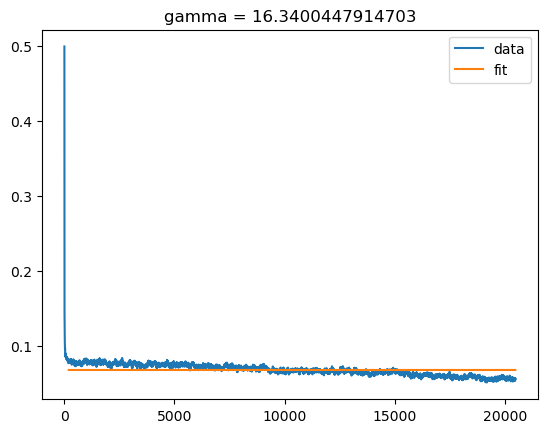

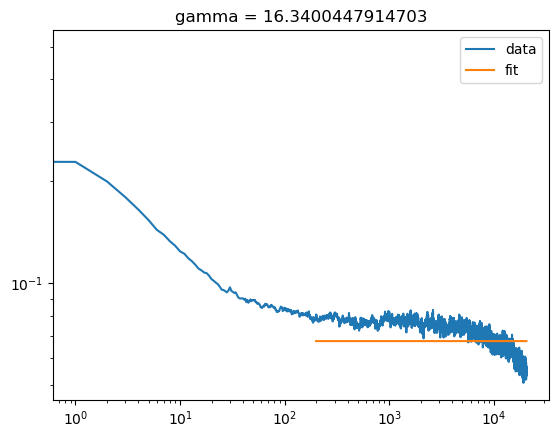

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1521551724137931


100%|██████████| 100/100 [20:38<00:00, 12.39s/it]


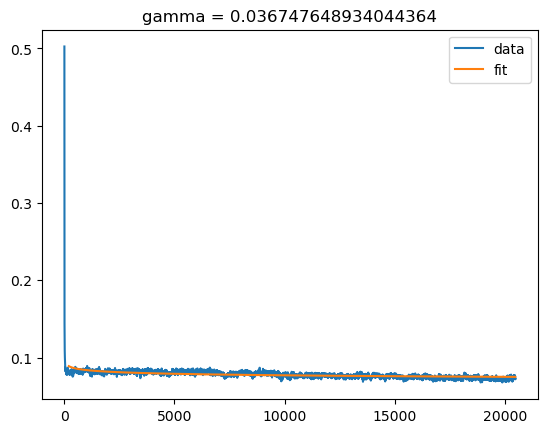

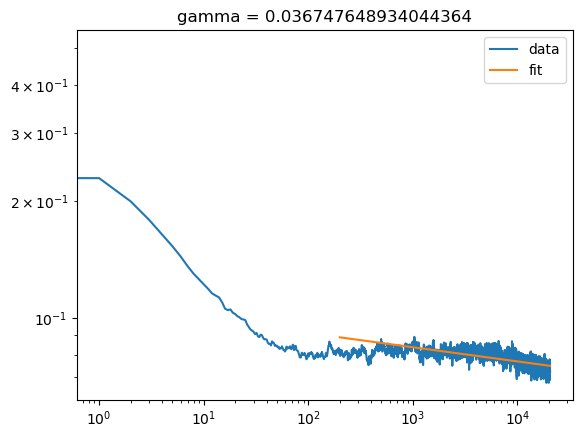

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15237068965517242


100%|██████████| 100/100 [20:50<00:00, 12.51s/it]


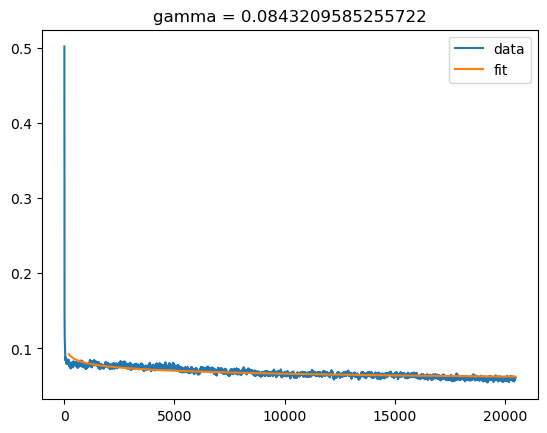

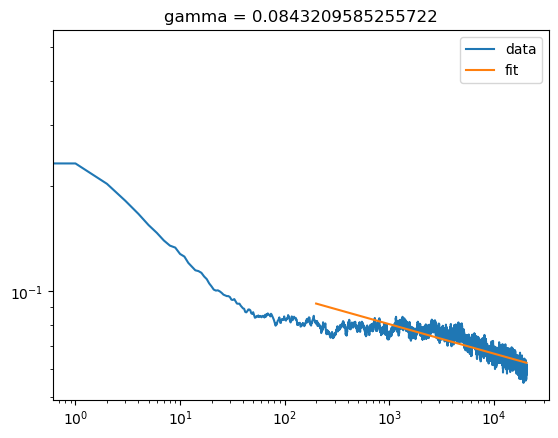

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15258620689655172


100%|██████████| 100/100 [19:42<00:00, 11.82s/it]


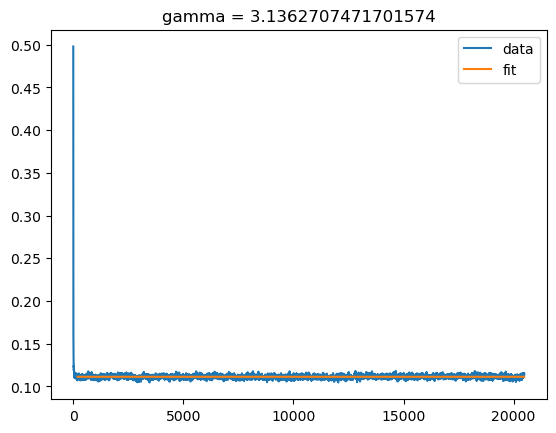

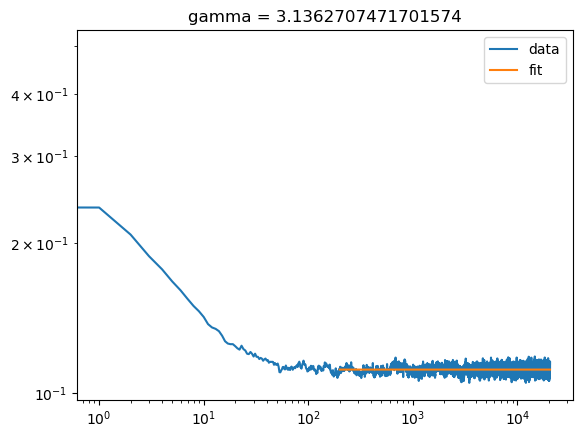

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15280172413793103


100%|██████████| 100/100 [19:36<00:00, 11.76s/it]


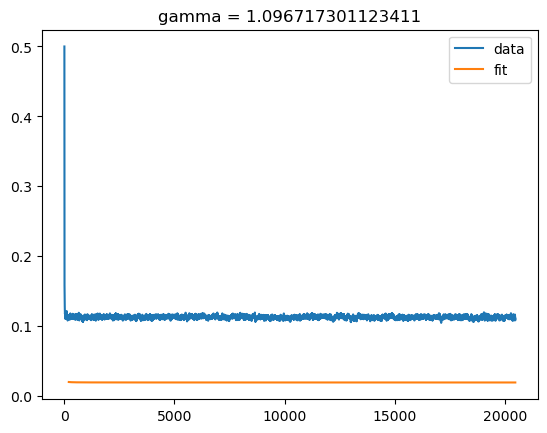

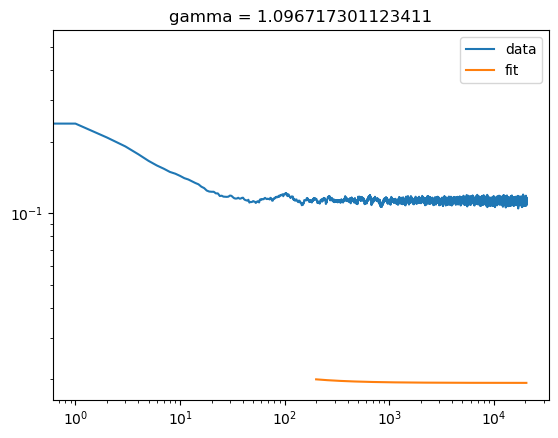

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15301724137931033


100%|██████████| 100/100 [20:03<00:00, 12.03s/it]


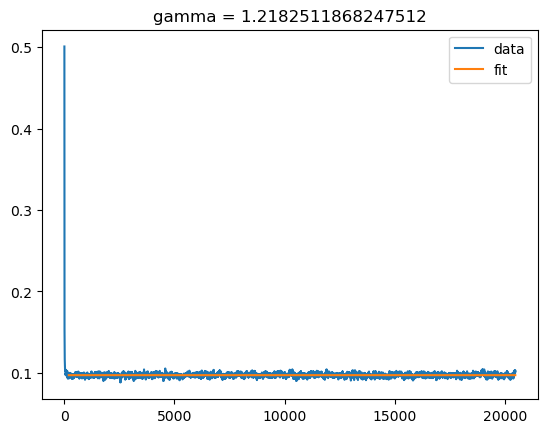

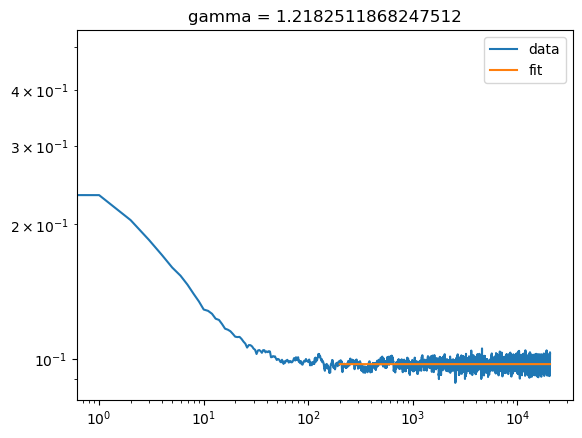

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15323275862068966


100%|██████████| 100/100 [20:29<00:00, 12.30s/it]


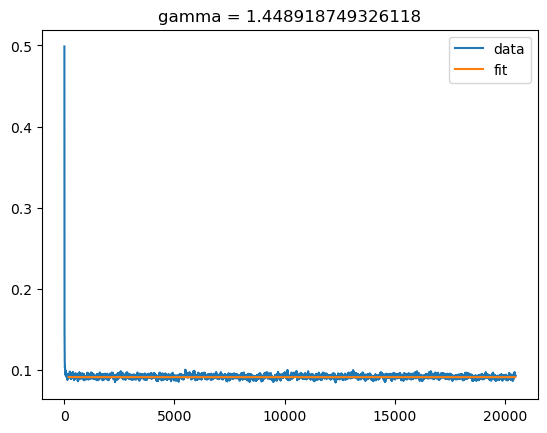

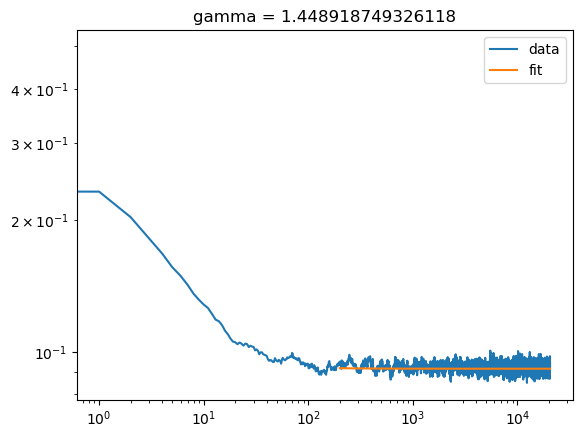

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15344827586206897


100%|██████████| 100/100 [20:03<00:00, 12.03s/it]


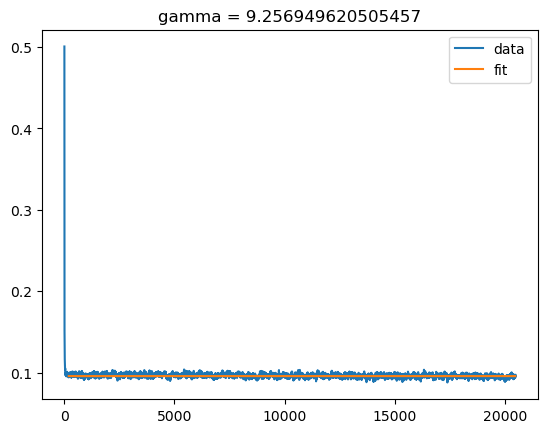

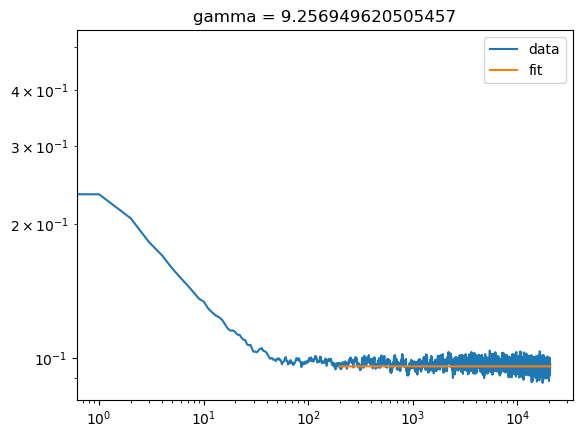

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15366379310344827


100%|██████████| 100/100 [20:10<00:00, 12.10s/it]


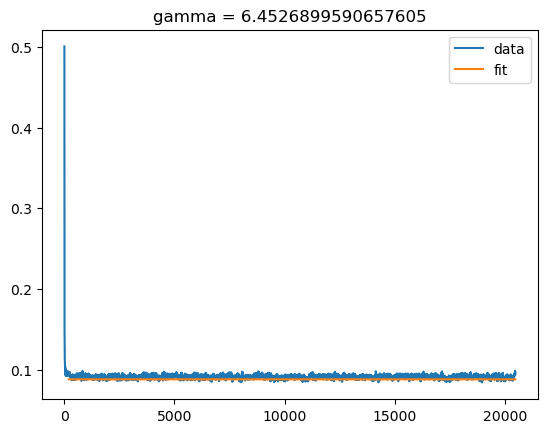

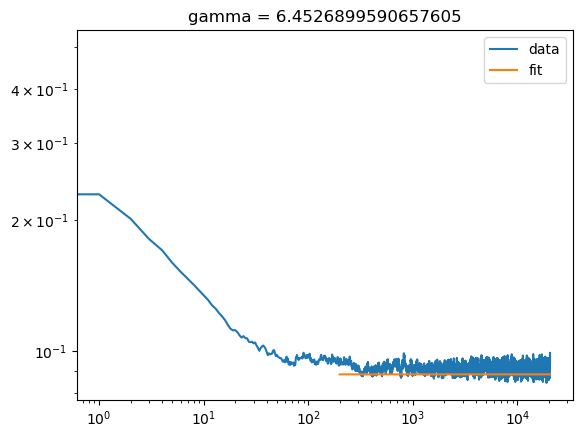

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15387931034482757


100%|██████████| 100/100 [19:52<00:00, 11.92s/it]


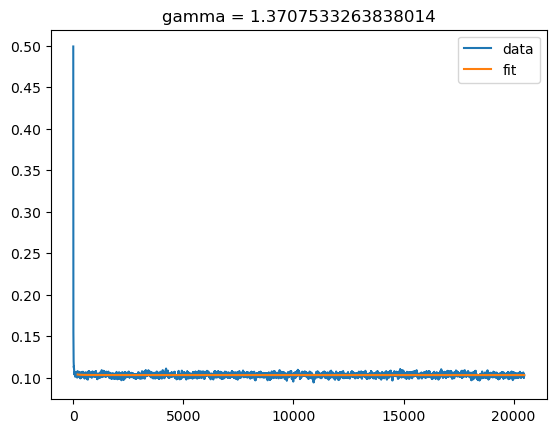

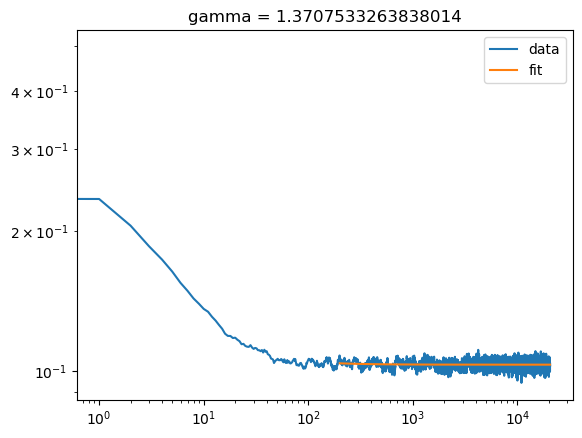

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1540948275862069


100%|██████████| 100/100 [19:44<00:00, 11.85s/it]


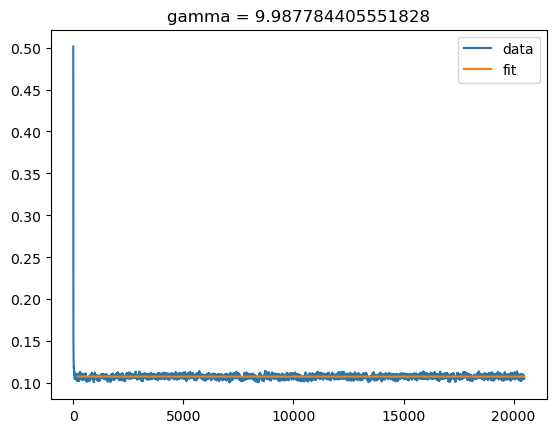

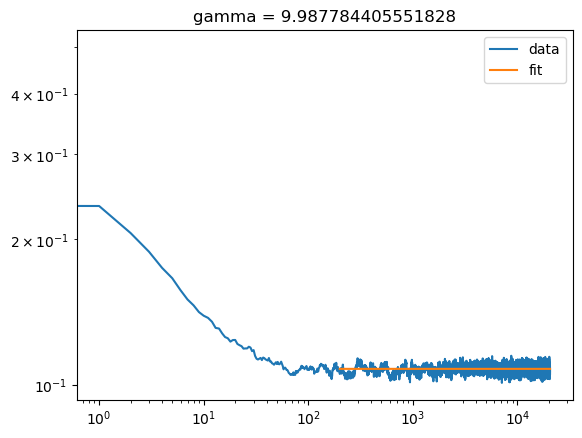

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1543103448275862


100%|██████████| 100/100 [20:15<00:00, 12.16s/it]


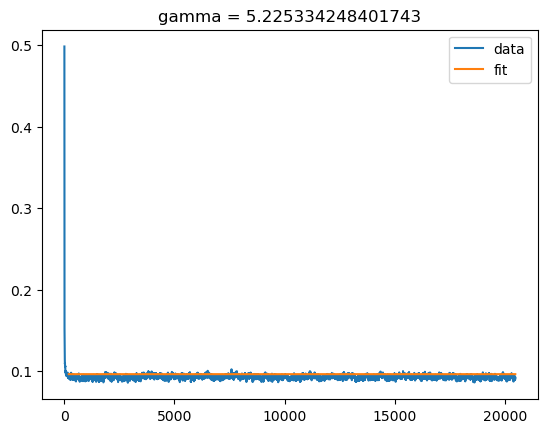

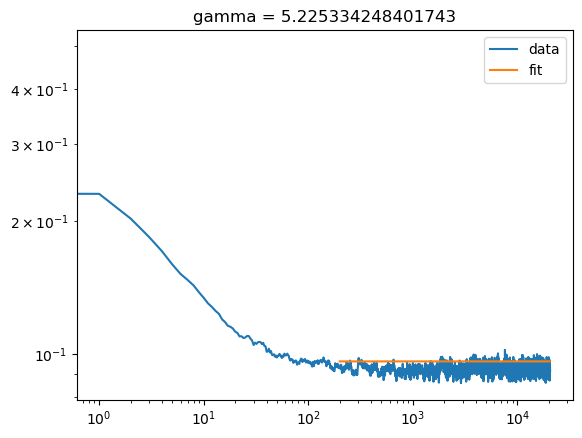

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1545258620689655


100%|██████████| 100/100 [20:01<00:00, 12.01s/it]


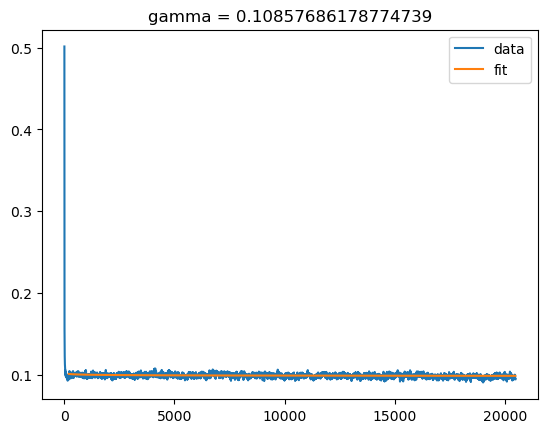

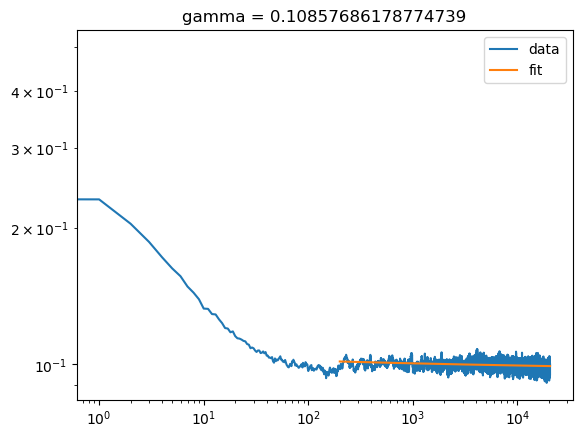

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15474137931034482


100%|██████████| 100/100 [20:23<00:00, 12.23s/it]


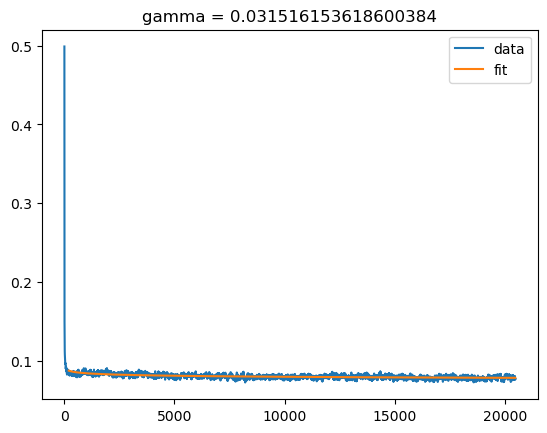

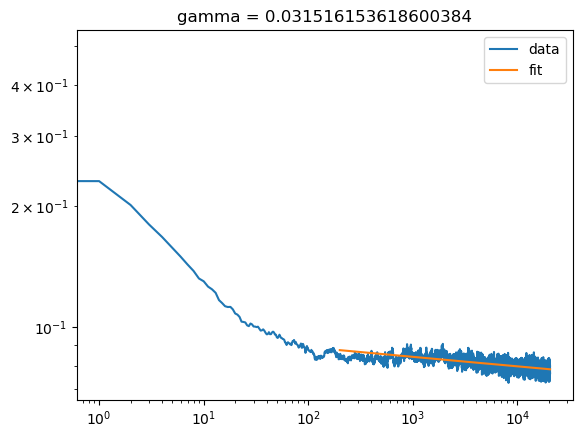

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15495689655172415


100%|██████████| 100/100 [19:30<00:00, 11.71s/it]


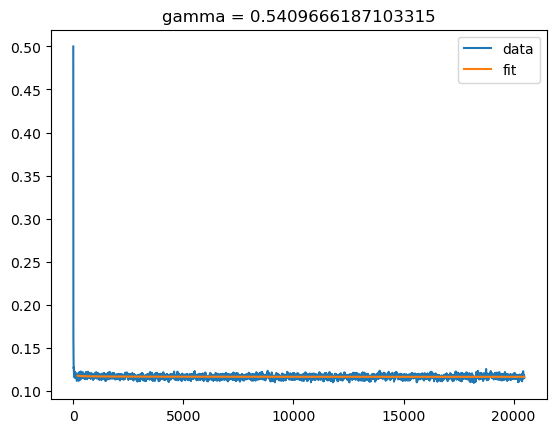

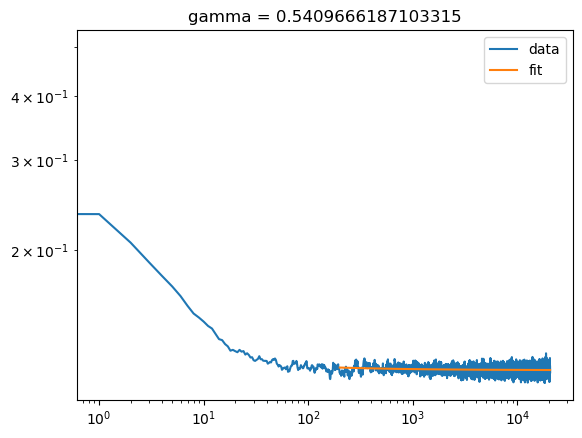

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15517241379310345


100%|██████████| 100/100 [19:58<00:00, 11.98s/it]


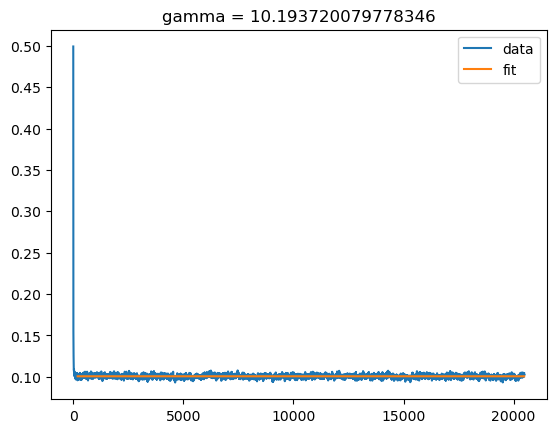

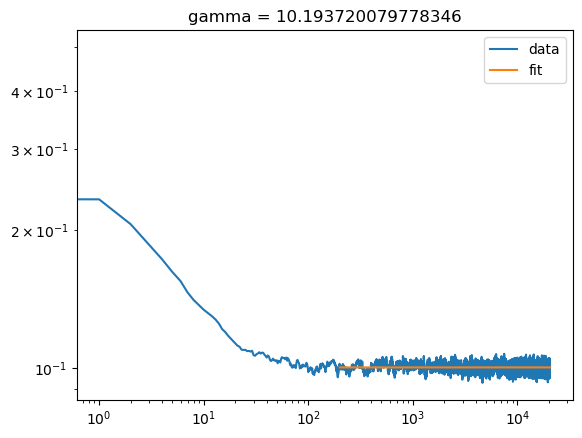

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15538793103448276


100%|██████████| 100/100 [19:38<00:00, 11.79s/it]


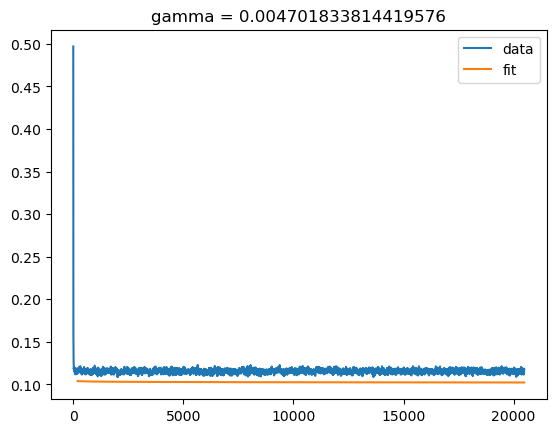

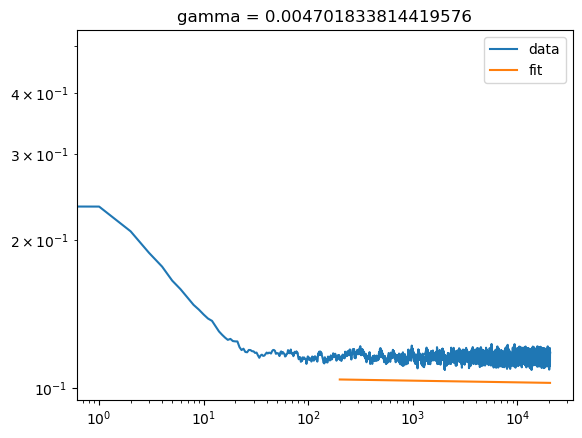

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15560344827586206


100%|██████████| 100/100 [19:39<00:00, 11.80s/it]


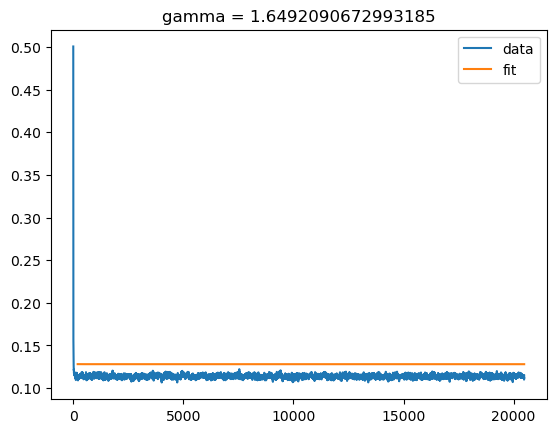

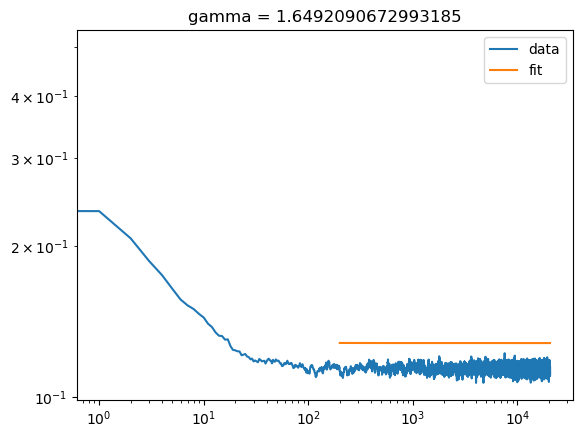

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1558189655172414


100%|██████████| 100/100 [19:32<00:00, 11.73s/it]


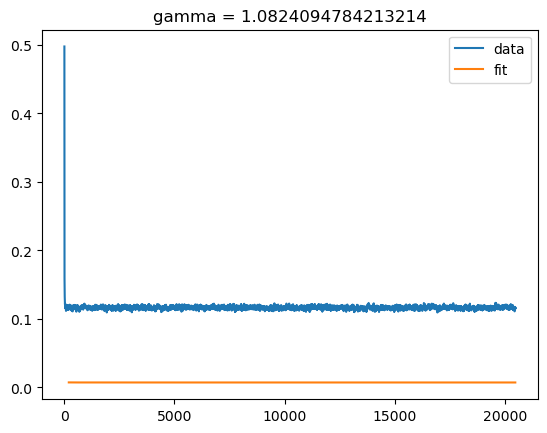

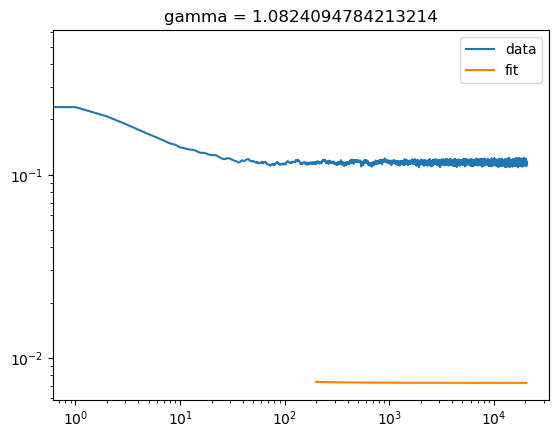

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.1560344827586207


100%|██████████| 100/100 [19:40<00:00, 11.81s/it]


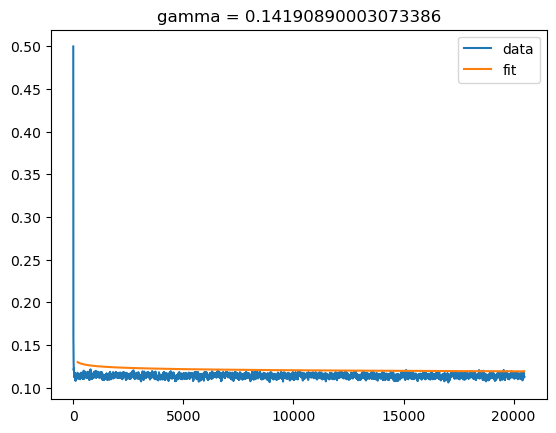

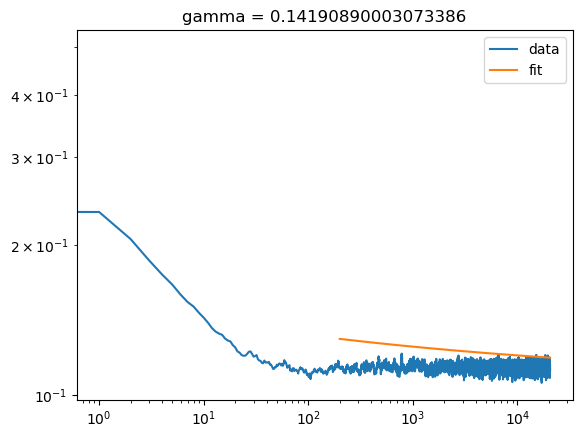

Connecting level 0 ...
Connecting level 1 ...
Connecting level 2 ...
Connecting level 3 ...
Connecting level 4 ...
Connecting level 5 ...
Connecting level 6 ...
Connecting level 7 ...
Connecting level 8 ...
Trying out kappa = 0.15625


100%|██████████| 100/100 [20:34<00:00, 12.35s/it]


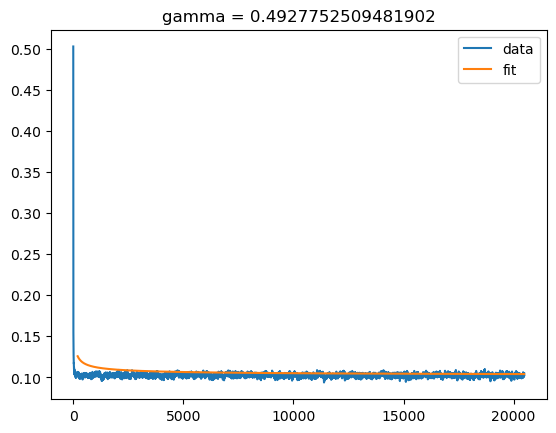

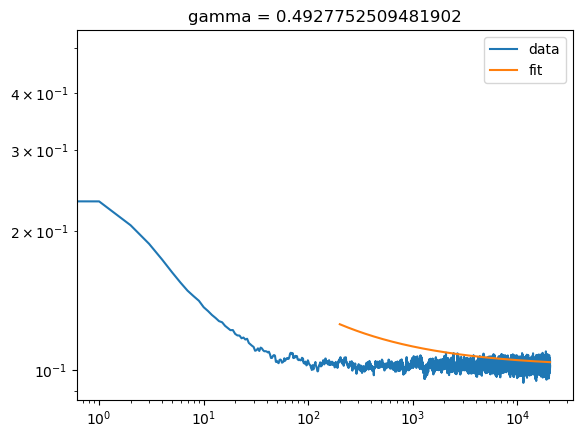

In [7]:
num_rep = 100
T = 1024 * 20
num_trials = 30
kappa_min = 0.15
kappa_max = 0.15625

determine_kappa_auto(num_rep, T, num_trials, kappa_min, kappa_max, start=200)

Trying out kappa = 0.15237068965517242


100%|██████████| 100/100 [1:52:38<00:00, 67.58s/it]


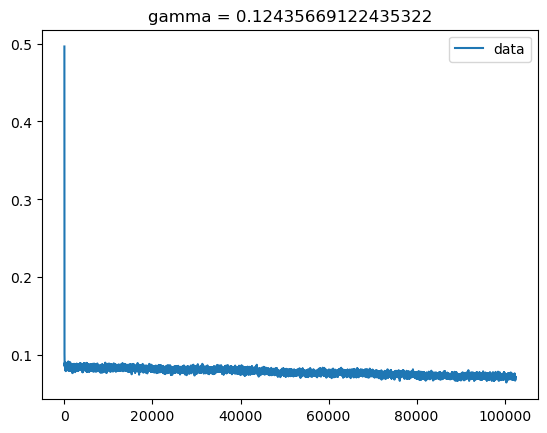

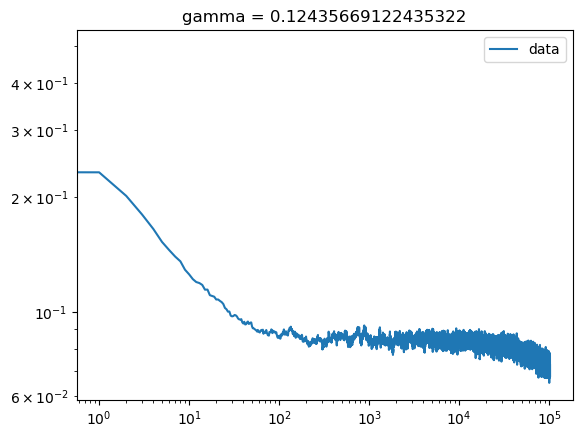

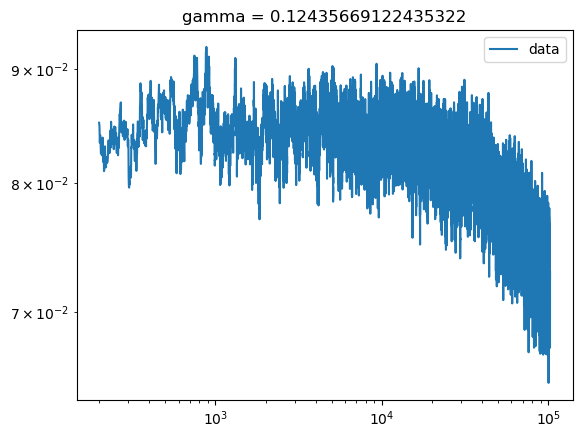

Trying out kappa = 0.15247844827586207


100%|██████████| 100/100 [1:49:10<00:00, 65.50s/it]


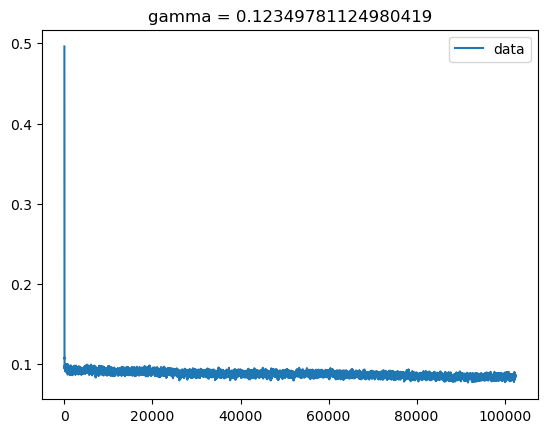

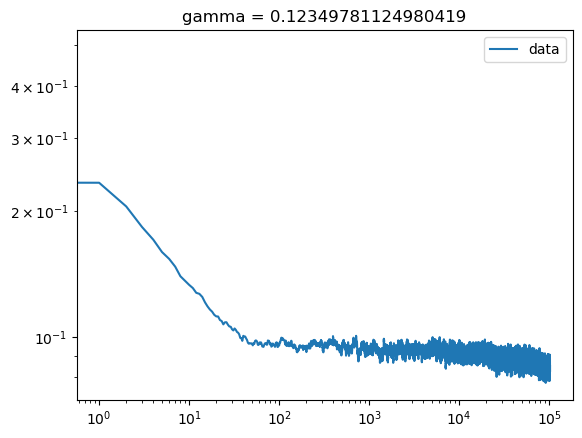

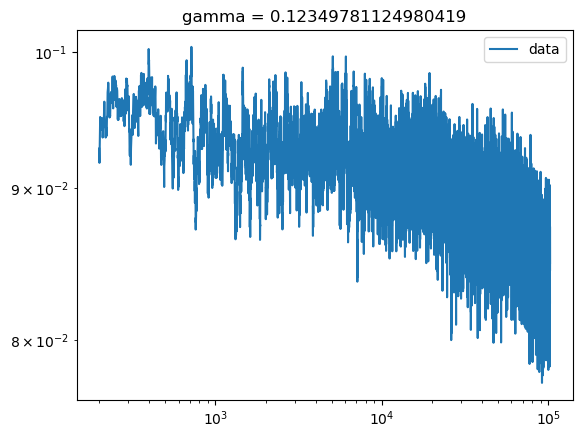

Trying out kappa = 0.15258620689655172


100%|██████████| 100/100 [1:47:47<00:00, 64.67s/it]


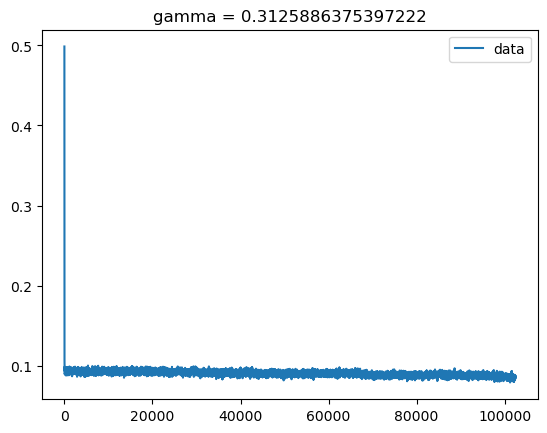

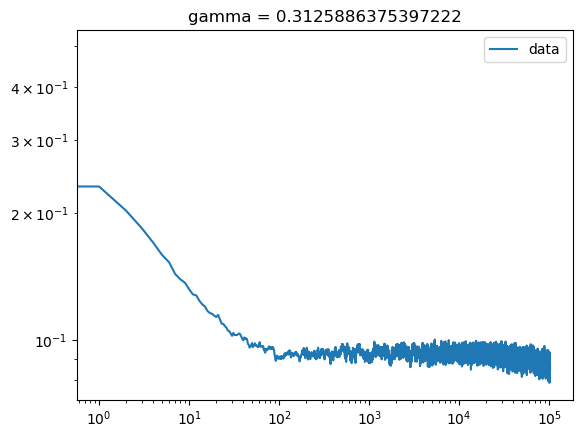

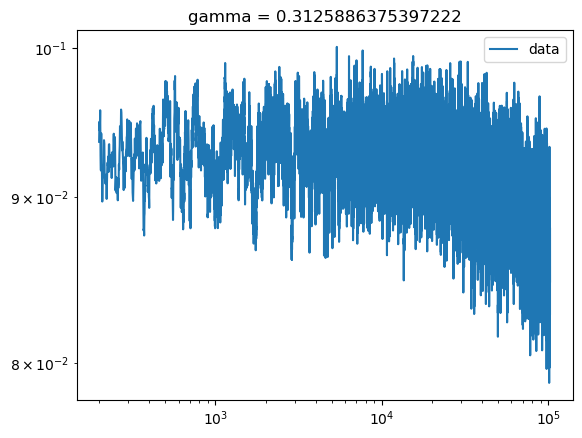

In [5]:
num_rep = 100
T = 1024 * 100
num_trials = 3
kappa_min = 0.15237068965517242
kappa_max = 0.15258620689655172
# kappa_min = 0.1525
# kappa_max = 0.16

determine_kappa_auto(num_rep, T, num_trials, kappa_min, kappa_max, start=200)

In [6]:
num_rep = 100
T = 1024 * 100
num_trials = 1
kappa_min = 0.15
kappa_max = 0.15
# kappa_min = 0.1525
# kappa_max = 0.16

determine_kappa_auto(num_rep, T, num_trials, kappa_min, kappa_max, start=200)

Trying out kappa = 0.15


 13%|█▎        | 13/100 [18:02<2:00:08, 82.86s/it]